# Simple Example with map_partitions

LSDB/HATS catalogs are organized into partitions, and this number of partitions is reported as `npartitions=` in the header, whenever printing a catalog.

This can be used to distribute operations across the catalog with maximum efficiency.

In [1]:
import lsdb
gaia_root = "https://data.lsdb.io/hats"
gaia3 = lsdb.read_hats(
    f"{gaia_root}/gaia_dr3/gaia",
    margin_cache=f"{gaia_root}/gaia_dr3/gaia_10arcs",
    search_filter=lsdb.ConeSearch(ra=280,
                                  dec=-60,
                                  radius_arcsec=2*3600),
    columns=[
                "source_id",
                "ra",
                "dec",
                "phot_g_mean_mag",
            ],
)
gaia3

Dask NestedFrame Structure:
                          source_id               ra              dec  phot_g_mean_mag
npartitions=4                                                                         
3314649325744685056  int64[pyarrow]  double[pyarrow]  double[pyarrow]  double[pyarrow]
3315775225651527680             ...              ...              ...              ...
3316901125558370304             ...              ...              ...              ...
3318027025465212928             ...              ...              ...              ...
3319152925372055552             ...              ...              ...              ...
Dask Name: search_points, 5 expressions
Expr=MapPartitions(search_points)

In [2]:
# You can get the number of partitions programmatically this way.
# This can be valuable when you want to choose the optimal number
# of workers to process the partitions.
len(gaia3.get_healpix_pixels())

4

In [3]:
# The individual elements of that list are HealpixPixel objects whose order
# and pixel you can inspect, if desired.
px = gaia3.get_healpix_pixels()[0]
px.order, px.pixel

(np.int64(4), np.int64(2944))

## What you can map

The trick is understanding what kind of function you can pass to `.map_partitions`.  Your function is going to receive a Pandas DataFrame as its first parameter.  Other parameters can be passed in as keyword arguments
to `.map_partitions`, as you'll see below.

Because the catalog is loaded lazily, `.map_partitions` also returns a lazy, or unevaluated, result.  You can realize it by either calling `.compute()` or `.to_hats()`.

So the input is a `pd.DataFrame` that is a partition of the catalog, and the output needs to be the same.

## What you get

The output of `.map_partitions` will contain *one row per partition*, so you will need to do additional reduction on the result in order to get a single final result.

In [4]:
# Given a target column, produce a DataFrame that has nothing but
# the min and max values for that column.
#
# Note that the function must work correctly when given an empty DataFrame
# as an input, too; if not, you're obliged to provide "meta", that is,
# information about argument type and shape.  It's certainly easier to
# simply handle DataFrames when you can.
import pandas as pd
def find_stats(df, pixel, target_column=''):
    min_val = df[target_column].min()
    max_val = df[target_column].max()
    return pd.DataFrame([{
        "pixel": pixel,
        f"{target_column}_min": min_val,
        f"{target_column}_max": max_val,
    }])

In [5]:
# Using include_pixel=True passes the HEALPix number of the partition
# to the function.
unrealized = gaia3.map_partitions(
    find_stats,
    include_pixel=True,
    # Keyword arguments after 'include_pixel=' are passed to your
    # function
    target_column="phot_g_mean_mag",
)

In [7]:
%%time
# Knowing that there are 4 partitions, we can tune our workers
# to take advantage of this.
npartitions = len(unrealized.get_healpix_pixels())
from dask.distributed import Client
with Client(n_workers=npartitions) as client:
    result = unrealized.compute()
result

/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36169 instead
  warnings.warn(


CPU times: user 356 ms, sys: 61 ms, total: 416 ms
Wall time: 7.84 s


pixel  phot_g_mean_mag_min  phot_g_mean_mag_max
0  Order: 4, Pixel: 2944             8.154537            22.033451
0  Order: 4, Pixel: 2945             5.508409            22.345750
0  Order: 4, Pixel: 2946             6.264917            22.076380
0  Order: 4, Pixel: 2947             6.154421            21.986425

In [8]:
# You can see that the objects in the 'pixel' column are the
# same type as from get_healpix_pixels().
type(result['pixel'].iloc[0])

hats.pixel_math.healpix_pixel.HealpixPixel

In [9]:
# Because the result is one row per partition, we need additional reduction
# to get our single answer
result['phot_g_mean_mag_min'].min(), result['phot_g_mean_mag_max'].max()

(5.508409, 22.34575)

In [10]:
# What about searching not only four partitions, but the
# whole catalog?
gaia3_all = lsdb.read_hats(
    f"{gaia_root}/gaia_dr3/gaia",
    margin_cache=f"{gaia_root}/gaia_dr3/gaia_10arcs",
    columns=[
                "source_id",
                "ra",
                "dec",
                "phot_g_mean_mag",
            ],
)
unrealized = gaia3_all.map_partitions(
    find_stats,
    include_pixel=True,
    # Keyword arguments after 'include_pixel=' are passed to your
    # function
    target_column="phot_g_mean_mag",
)
npartitions = len(unrealized.get_healpix_pixels())

In [11]:
npartitions

3933

In [12]:
%%time
# You can run the same function on all partitions, but it will take longer,
# like a 6 or 7 minutes.
#
# That's a lot of partitions!  To keep from overwhelming our cluster, we'll
# bound this value.  It's light on compute, so use many threads per process.
with Client(n_workers=min(8, npartitions), threads_per_worker=4) as client:
    result = unrealized.compute()
result

/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44029 instead
  warnings.warn(


2025-03-17 23:14:31,500 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/distributed/comm/tcp.py", line 226, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/distributed/worker.py", line 1269, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/distributed/utils_comm.py", line 416, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
  File "/opt

/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/distributed/utils_comm.py", line 395, in retry
    return await coro()
           ^^^^^^^^^^^^
  File "/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/distributed/core.py", line 1259, in send_recv_from_rpc
    return await send_recv(comm=comm, op=key, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/distributed/core.py", line 1018, in send_recv
    response = await comm.read(deserializers=deserializers)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/distributed/comm/tcp.py", line 237, in read
    convert_stream_closed_error(self, e)
  File "/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/distributed/comm/tcp.py", line 137

CPU times: user 1min 21s, sys: 6.17 s, total: 1min 27s
Wall time: 6min 52s


pixel  phot_g_mean_mag_min  phot_g_mean_mag_max
0      Order: 2, Pixel: 0             3.382374            22.452248
0      Order: 3, Pixel: 4             3.836123            22.281105
..                    ...                  ...                  ...
0   Order: 4, Pixel: 3067             6.026669            22.432905
0    Order: 3, Pixel: 767             3.449377            22.423697

[3933 rows x 3 columns]

In [13]:
# We need to do a final reduction step to get the true min and max
result['phot_g_mean_mag_min'].min(), result['phot_g_mean_mag_max'].max()

(1.731607, 22.956425)

In [14]:
# Since we just searched the whole catalog, we can check our answer
# against the statistics that were compiled at import time for the
# catalog.  As you can see, they match what we got when using
# the .map_partitions method.
gaia3_all.hc_structure.aggregate_column_statistics(include_columns='phot_g_mean_mag')

min_value  max_value  null_count
column_names                                     
phot_g_mean_mag   1.731607  22.956425   5455339.0

## Generating New Columns

Since the partition's `DataFrame` is passed in to you, you can
augment it with new columns based on the existing columns,
in ordinary Pandas style.

In [15]:
def mean_sq(df, pixel):
    df["phot_g_mean_mag_sq"] = df["phot_g_mean_mag"] ** 2
    return df

unrealized = gaia3.map_partitions(mean_sq, include_pixel=True)
unrealized

Dask NestedFrame Structure:
                          source_id               ra              dec  phot_g_mean_mag phot_g_mean_mag_sq
npartitions=4                                                                                            
3314649325744685056  int64[pyarrow]  double[pyarrow]  double[pyarrow]  double[pyarrow]    double[pyarrow]
3315775225651527680             ...              ...              ...              ...                ...
3316901125558370304             ...              ...              ...              ...                ...
3318027025465212928             ...              ...              ...              ...                ...
3319152925372055552             ...              ...              ...              ...                ...
Dask Name: nestedframe, 7 expressions
Expr=MapPartitions(NestedFrame)

In [16]:
%%time
from dask.distributed import Client
with Client(n_workers=4) as client:
    result = unrealized.compute()
result

/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42777 instead
  warnings.warn(


CPU times: user 381 ms, sys: 89.7 ms, total: 471 ms
Wall time: 7.9 s


source_id          ra        dec  \
_healpix_29                                                       
3315212135629220059  6630424242158614528  279.475941 -61.973682   
3315212197603296958  6630424379597543936   279.40738 -61.977054   
...                                  ...         ...        ...   
3318663093295462547  6637326190180387584  280.426265 -58.015067   
3318663093808668415  6637326185883831296  280.423503 -58.013744   

                     phot_g_mean_mag  phot_g_mean_mag_sq  
_healpix_29                                               
3315212135629220059        20.157476          406.323839  
3315212197603296958        19.488537          379.803074  
...                              ...                 ...  
3318663093295462547        21.097507          445.104802  
3318663093808668415        20.301455          412.149075  

[469102 rows x 5 columns]

No reduction step is needed here since the operation is not a reducing operation.
There are as many rows in the new output as there were in the input.

## Histograms

As another example, suppose we want to bin observations by magnitude
in the G band.  We'll need to load different columns than before,
since we didn't include observations earlier.

This is more than the straightforward `.hist()` method on `DataFrame`
because each row contains some number of observations, and we want
to sum these observations within each magnitude bin.

In [17]:
import lsdb
gaia3 = lsdb.read_hats(
    f"{gaia_root}/gaia_dr3/gaia",
    margin_cache=f"{gaia_root}/gaia_dr3/gaia_10arcs",
    search_filter=lsdb.ConeSearch(ra=280,
                                  dec=-60,
                                  radius_arcsec=2*3600),
    columns=[
        "source_id",
        "ra",
        "dec",
        "phot_g_mean_mag",
        "phot_g_n_obs",
    ],
)
gaia3

Dask NestedFrame Structure:
                          source_id               ra              dec  phot_g_mean_mag    phot_g_n_obs
npartitions=4                                                                                         
3314649325744685056  int64[pyarrow]  double[pyarrow]  double[pyarrow]  double[pyarrow]  int64[pyarrow]
3315775225651527680             ...              ...              ...              ...             ...
3316901125558370304             ...              ...              ...              ...             ...
3318027025465212928             ...              ...              ...              ...             ...
3319152925372055552             ...              ...              ...              ...             ...
Dask Name: search_points, 5 expressions
Expr=MapPartitions(search_points)

### All Within Memory

First, what does it look like to do it all within memory?

In [18]:
%%time
df = gaia3.compute()
df

CPU times: user 865 ms, sys: 370 ms, total: 1.24 s
Wall time: 3.85 s


source_id          ra        dec  \
_healpix_29                                                       
3315212135629220059  6630424242158614528  279.475941 -61.973682   
3315212197603296958  6630424379597543936   279.40738 -61.977054   
...                                  ...         ...        ...   
3318663093295462547  6637326190180387584  280.426265 -58.015067   
3318663093808668415  6637326185883831296  280.423503 -58.013744   

                     phot_g_mean_mag  phot_g_n_obs  
_healpix_29                                         
3315212135629220059        20.157476           298  
3315212197603296958        19.488537           346  
...                              ...           ...  
3318663093295462547        21.097507            42  
3318663093808668415        20.301455           336  

[469102 rows x 5 columns]

Note that the four partitions become over 450k rows once they are computed.  The lazily-loaded
catalog can't show you how many total rows there are before computing, only the number of
partitions.

In [19]:
from matplotlib import pyplot as plt

mag_bins = list(range(5, 25, 1))
plt.hist(df['phot_g_mean_mag'], bins=mag_bins, weights=df['phot_g_n_obs'])
plt.yscale('log')

This is a small enough amount of data that it's easy to handle it
in-memory.  But we wouldn't be able to do this on the whole Gaia3
catalog.  For that, we'll need to use `.map_partitions`, and we'll
test this function on the same small piece of data before launching
it across the entire catalog.

The first step is to understand that we'll be creating partial histograms,
that is, a histogram for each partition, and we'll need to reduce those
down to a single histogram at the end.  One consequence of this is
the need to have the same number of bins in each partial histogram,
`mag_bins` in this case.  Often when producing a histogram, it's common
to let Pandas or `pd.cut` pick the bin boundaries given a number of
bins, but that will work against us in this case, since each partition
will have a different min and max, and the partial histograms won't
reduce.

In [20]:
# This function only requires and returns one DataFrame: no pixel
# argument, no additional arguments.
def observation_histogram(df):
    df['binned'] = pd.cut(df['phot_g_mean_mag'], mag_bins)
    binned_data = df.groupby('binned', observed=True)['phot_g_n_obs'].sum()
    return binned_data

First, we test our new function on our single in-memory `DataFrame`, to
see that we get the results we expect.

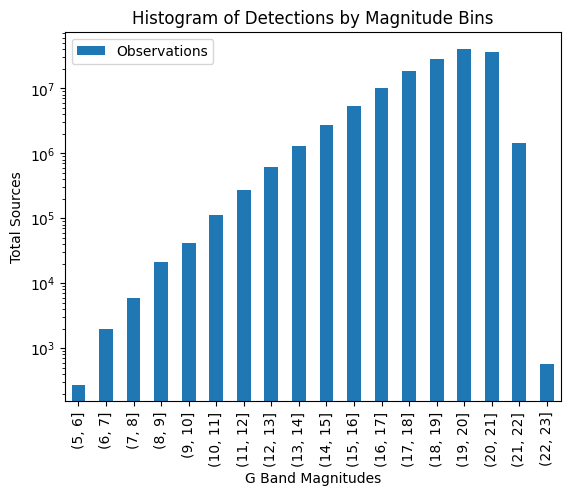

In [21]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

bd = observation_histogram(df)

bd.plot(kind='bar', ax=ax, label='Observations')

ax.set_title('Histogram of Detections by Magnitude Bins')
ax.set_xlabel('G Band Magnitudes')
ax.set_ylabel('Total Sources')

ax.legend()
ax.set_yscale('log')

plt.show()

### Using map_partitions

The above went pretty quickly, because our cone search is keeping our data small.
But if it were a much larger slice of the sky, this next technique would matter
more.

As before, `.map_partitions` will give us one result per partition, so we need
to be prepared to do a final combination step.

In [22]:
unrealized = gaia3.map_partitions(observation_histogram)
unrealized

/home/dtj1s/.local/lib/python3.12/site-packages/lsdb/catalog/dataset/healpix_dataset.py:303: RuntimeWarning: output of the function must be a DataFrame to generate an LSDB `Catalog`. `map_partitions` will return a dask object instead of a Catalog.
  warnings.warn(


Dask Series Structure:
npartitions=4
3314649325744685056    int64[pyarrow]
3315775225651527680               ...
3316901125558370304               ...
3318027025465212928               ...
3319152925372055552               ...
Dask Name: observation_histogram, 6 expressions
Expr=MapPartitions(observation_histogram)

In [23]:
# The result of `.map_partitions` has the number of partitions as
# a top-level attribute.
unrealized.npartitions

4

In [24]:
%%time
from dask.distributed import Client
with Client(n_workers=unrealized.npartitions) as client:
    result = unrealized.compute()
# This is actually the histogram repeated for each partition.
pd.DataFrame({'binned': result})

/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38517 instead
  warnings.warn(


CPU times: user 399 ms, sys: 59.9 ms, total: 459 ms
Wall time: 8.3 s


binned
binned            
(8, 9]        2811
(9, 10]       4784
...            ...
(20, 21]  11124220
(21, 22]    493954

[65 rows x 1 columns]

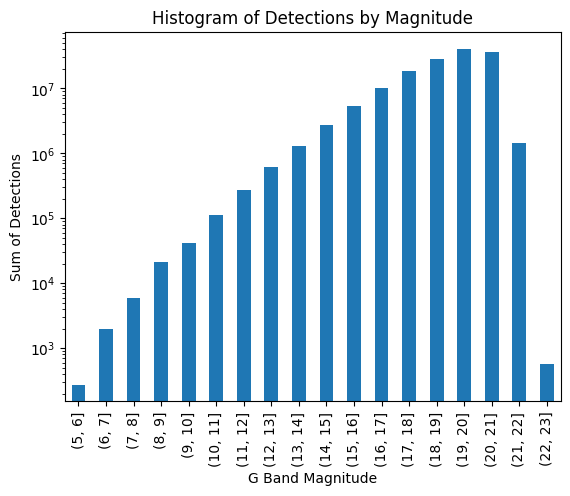

In [25]:
# Final reduction step
total_histogram = result.groupby('binned', observed=True).sum()

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
total_histogram.plot(kind='bar', ax=ax)
ax.set_title('Histogram of Detections by Magnitude')
ax.set_xlabel('G Band Magnitude')
ax.set_ylabel('Sum of Detections')
ax.set_yscale('log')
plt.show()

And now compare the result and timing to running this histogram on
the entire catalog.

In [26]:
gaia3 = lsdb.read_hats(
    f"{gaia_root}/gaia_dr3/gaia",
    margin_cache=f"{gaia_root}/gaia_dr3/gaia_10arcs",
    columns=[
        "source_id",
        "ra",
        "dec",
        "phot_g_mean_mag",
        "phot_g_n_obs",
    ],
)
unrealized = gaia3.map_partitions(observation_histogram)
unrealized

/home/dtj1s/.local/lib/python3.12/site-packages/lsdb/catalog/dataset/healpix_dataset.py:303: RuntimeWarning: output of the function must be a DataFrame to generate an LSDB `Catalog`. `map_partitions` will return a dask object instead of a Catalog.
  warnings.warn(


Dask Series Structure:
npartitions=3933
0                      int64[pyarrow]
18014398509481984                 ...
                            ...      
3454260914193170432               ...
3458764513820540928               ...
Dask Name: observation_histogram, 4 expressions
Expr=MapPartitions(observation_histogram)

In [27]:
%%time
from dask.distributed import Client
# Takes 8-10 minutes
with Client(n_workers=min(8, unrealized.npartitions), threads_per_worker=4) as client:
    result = unrealized.compute()
# This is actually the histogram repeated for each partition.
pd.DataFrame({'binned': result})

/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36751 instead
  warnings.warn(


CPU times: user 1min 27s, sys: 7.31 s, total: 1min 35s
Wall time: 8min 31s


binned
binned           
(5, 6]       3297
(6, 7]       7250
...           ...
(21, 22]  4548691
(22, 23]     7823

[64599 rows x 1 columns]

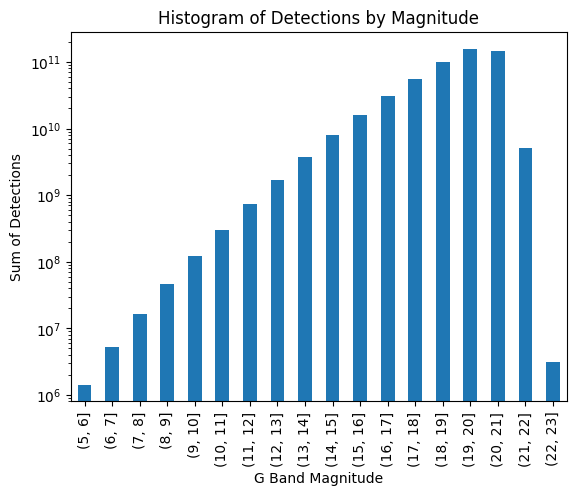

In [28]:
# Final reduction
total_histogram = result.groupby('binned', observed=True).sum()

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
total_histogram.plot(kind='bar', ax=ax)
ax.set_title('Histogram of Detections by Magnitude')
ax.set_xlabel('G Band Magnitude')
ax.set_ylabel('Sum of Detections')
ax.set_yscale('log')
plt.show()

The histogram has the same shape but a different Y-axis, as is reasonable:
our small cone search had picked a part of the sky which was representative
of the whole, but processing the entire catalog increased the number
of observations across all bins.